# Проект: вариант 4

## Задание №1

Подключение необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode
import json

from statistics import mean
from scipy.stats import norm, mode, chi2_contingency

Загрузка данных с Яндекс.Диск

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# active_users - информация о пользователях, которые посещали приложение во время эксперимента
public_key = 'https://disk.yandex.ru/d/B4QnY5D5EtKa-A'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
h = json.loads(response.text)['href']
active_users = pd.read_csv(h, sep=',')

# groups - разбивка пользователей на контрольную (А) и тестовую (В) группы
public_key = 'https://disk.yandex.ru/d/jP_BAw_oxS3law'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
h = json.loads(response.text)['href']
groups = pd.read_csv(h, sep=',')

# purchases - данные о транзакциях (оплатах) пользователей приложения во время эксперимента
public_key = 'https://disk.yandex.ru/d/AmucCdboEaowhA'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
h = json.loads(response.text)['href']
purchases = pd.read_csv(h, sep=',')

Просмотр информации по датафреймам, проверка на пропуски и уникальные значения 

In [3]:
active_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   8341 non-null   int64 
 1   country   8341 non-null   object
 2   platform  8341 non-null   object
 3   sex       8341 non-null   object
dtypes: int64(1), object(3)
memory usage: 260.8+ KB


In [4]:
active_users.isna().sum()

user_id     0
country     0
platform    0
sex         0
dtype: int64

In [5]:
active_users.nunique()

user_id     8341
country        2
platform       2
sex            2
dtype: int64

In [6]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  74576 non-null  int64 
 1   group    74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [7]:
groups.isna().sum()

user_id    0
group      0
dtype: int64

In [8]:
groups.nunique()

user_id    74576
group          2
dtype: int64

In [9]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  541 non-null    int64  
 1   revenue  541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [10]:
purchases.isna().sum()

user_id    0
revenue    0
dtype: int64

In [11]:
purchases.nunique()

user_id    541
revenue     98
dtype: int64

Соединение по user_id всех датафреймов в один df

In [12]:
df = active_users.merge(purchases, how='left', on='user_id')
df.revenue.fillna(0, inplace=True)
df.revenue = df['revenue'].astype(int)
df = df.merge(groups, on='user_id')
df['cps'] = df['country'] + '_' + df['platform'] + '_' + df['sex']  # для дашборда
df.to_csv('stories.csv')
df

,user_id,country,platform,sex,revenue,group,cps
0,8029,Russia,ios,male,0,B,Russia_ios_male
1,1735,Sweden,ios,male,0,B,Sweden_ios_male
2,7697,Russia,android,male,0,B,Russia_android_male
3,1421,Sweden,android,female,0,B,Sweden_android_female
4,1704,Russia,ios,male,0,B,Russia_ios_male
...,...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,0,B,Sweden_ios_female
8337,3755,Russia,ios,male,590,A,Russia_ios_male
8338,4594,Sweden,android,female,0,B,Sweden_android_female
8339,7430,Sweden,ios,female,0,B,Sweden_ios_female


Количество пользователей по прибыли

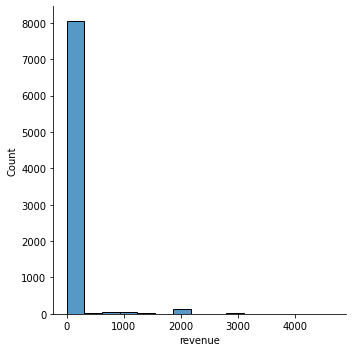

In [13]:
sns.displot(df.revenue, kde=False)

Как видно из прошлого графика, громадное число значений скорее всего равно 0. Соответственно, гораздо важнее увидеть закономерности при revenue > 0 

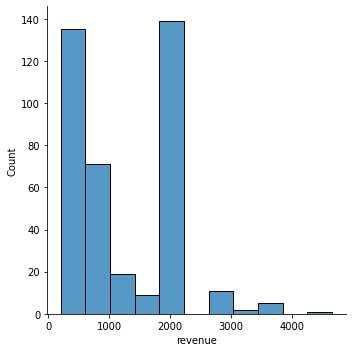

In [14]:
sns.displot(df[df.revenue > 0].revenue, kde=False)

Теперь важно рассмотреть, видна ли разница на графиках контрольной и тестовой группы

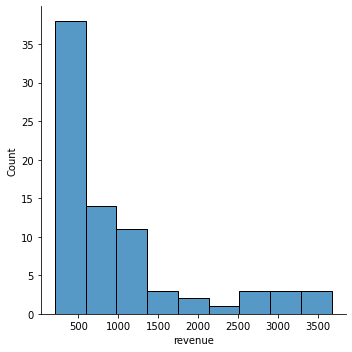

In [15]:
sns.displot(df[(df.group == 'A') & (df.revenue > 0)].revenue, kde=False)

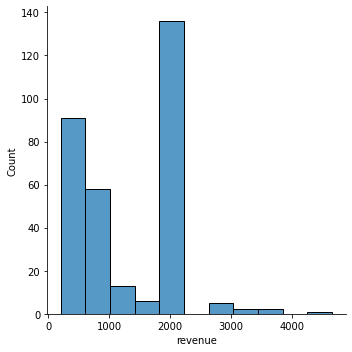

In [16]:
sns.displot(df[(df.group == 'B') & (df.revenue > 0)].revenue, kde=False)

Видно, что в процентом соотношении гораздо больше пользователей потратили около 2000.

Важно понять, отсутствует ли взаимосвязь между пользователями, которые совершили оплату, и группой эксперимента (нулевая гипотеза)

In [17]:
df['pay'] = df.revenue.apply(lambda x: 'pay' if x > 0 else 'not_pay')

In [18]:
pd.crosstab(df.pay, df.group)

group,A,B
pay,,
not_pay,1460,6489
pay,78,314


In [19]:
value_group = chi2_contingency(pd.crosstab(df.pay, df.group))
value_group[1]  # p_value

0.48625240457231045

Значение p-value намного превышает 0.05, следовательно, нет никаких оснований опровергнуть нулевую гипотезу об отсутствии взаимосвязи между переменными.

Требуется проверить, возможно где-то просто проблема с платформой, либо имеются предпочтения от страны или пола

In [20]:
pd.crosstab(df.pay, df.platform)

platform,android,ios
pay,,
not_pay,4413,3536
pay,208,184


In [21]:
value_platform = chi2_contingency(pd.crosstab(df.pay, df.platform))
value_platform[1]  # p_value

0.3667222543587335

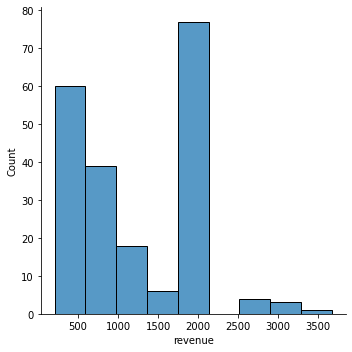

In [22]:
sns.displot(df[(df.platform == 'android') & (df.revenue > 0)].revenue, kde=False)

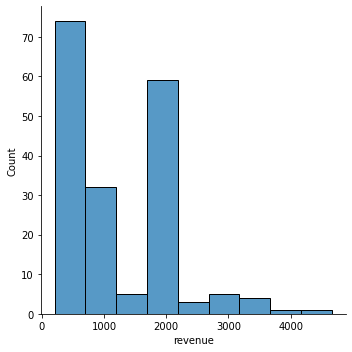

In [23]:
sns.displot(df[(df.platform == 'ios') & (df.revenue > 0)].revenue, kde=False)

In [24]:
pd.crosstab(df.pay, df.sex)

sex,female,male
pay,,
not_pay,3954,3995
pay,191,201


In [25]:
value_sex = chi2_contingency(pd.crosstab(df.pay, df.sex))
value_sex[1]  # p_value

0.7326210380083343

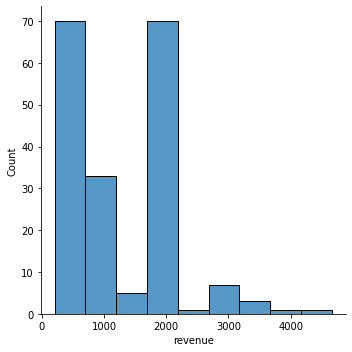

In [26]:
sns.displot(df[(df.sex == 'female') & (df.revenue > 0)].revenue, kde=False)

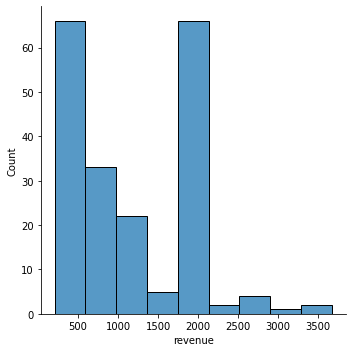

In [27]:
sns.displot(df[(df.sex == 'male') & (df.revenue > 0)].revenue, kde=False)

In [28]:
pd.crosstab(df.pay, df.country)

country,Russia,Sweden
pay,,
not_pay,5167,2782
pay,240,152


In [29]:
value_country = chi2_contingency(pd.crosstab(df.pay, df.country))
value_country[1]  # p_value

0.14027322855215643

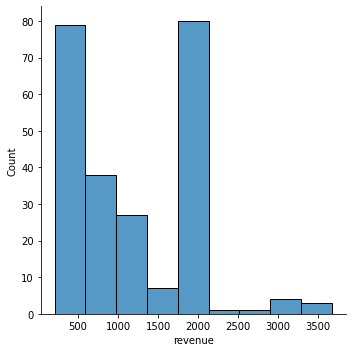

In [30]:
sns.displot(df[(df.country == 'Russia') & (df.revenue > 0)].revenue, kde=False)

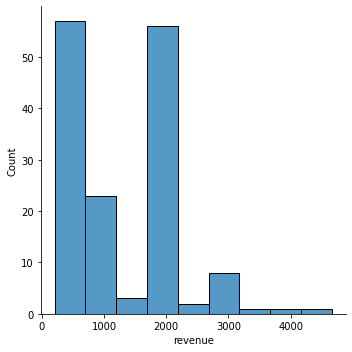

In [31]:
sns.displot(df[(df.country == 'Sweden') & (df.revenue > 0)].revenue, kde=False)

На основании вышеизложенных данных p-value и графиков невозможно прийти к выводу, что какая-то техническая проблема или предпочтение пола/страны.

В следующем блоке рассмотрены некоторые продуктовые метрики для контрольной и тестовой группы:
1. CR (конверсия) - отношение числа пользователей, которые принесли доход к общему числу пользователей;
2. ARPPU (средний доход на платящего пользователя) - высчитывается как отношение общего дохода на количество заплативших пользователей;
3. ARPU (средний доход с привлеченного пользователя) - произведение конверсии и среднего дохода на платящего пользователя.

In [32]:
CR_control = df[(df.revenue > 0) & (df.group == 'A')].shape[0] / df[df.group == 'A'].shape[0]
CR_control

0.05071521456436931

In [33]:
CR_test = df[(df.revenue > 0) & (df.group == 'B')].shape[0] / df[df.group == 'B'].shape[0]
CR_test

0.046156107599588415

In [34]:
if CR_control > CR_test:
    print("CR уменьшился на {0:.2f}%".format((CR_control / CR_test - 1) * 100))
elif CR_control < CR_test:
    print("CR увеличился на {0:.2f}%".format((CR_test / CR_control - 1) * 100))
else:
    print("CR не изменился")

CR уменьшился на 9.88%


In [35]:
ARPPU_control = df[df.group == 'A'].revenue.sum() / df[(df.revenue > 0) & (df.group == 'A')].shape[0]
ARPPU_control

943.5641025641025

In [36]:
ARPPU_test = df[df.group == 'B'].revenue.sum() / df[(df.revenue > 0) & (df.group == 'B')].shape[0]
ARPPU_test

1267.875796178344

In [37]:
if ARPPU_control > ARPPU_test:
    print("ARPPU уменьшился на {0:.2f}%".format((ARPPU_control / ARPPU_test - 1) * 100))
elif ARPPU_control < ARPPU_test:
    print("ARPPU увеличился на {0:.2f}%".format((ARPPU_test / ARPPU_control - 1) * 100))
else:
    print("ARPPU не изменился")

ARPPU увеличился на 34.37%


In [38]:
ARPU_control = CR_control * ARPPU_control
ARPU_control

47.85305591677503

In [39]:
ARPU_test = CR_test * ARPPU_test
ARPU_test

58.520211671321476

In [40]:
if ARPU_control > ARPU_test:
    print("ARPU уменьшился на {0:.2f}%".format((ARPU_control / ARPU_test - 1) * 100))
elif ARPU_control < ARPU_test:
    print("ARPU увеличился на {0:.2f}%".format((ARPU_test / ARPU_control - 1) * 100))
else:
    print("ARPU не изменился")

ARPU увеличился на 22.29%


В итоге, хоть конверсия и уменьшилась на 9.88%, но вот средний доход на пользователя увеличился на 22.29%.

Являются ли статистически значимыми изменения? Для проверки используется метод bootstrap. U-критерий Манна-Уитни не подходит, так как в выборках присутстуют повторяющиеся значения, а значит, будет потеряна точность.

H0 (нулевая гипотеза): Различий в доходах между двумя группами нет.

H1 (альтернативная гипотеза): Есть различия в доходах между двумя группами

In [41]:
def get_bootstrap(data_column_1, data_column_2, boot_it=2000, statistic=np.mean, bootstrap_conf_level=0.95):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in range(boot_it):
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)     
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
       
    return p_value

1.8497026676728492e-06
1.5019431620509883e-06
2.3744159396252247e-06
2.5674893224383675e-06
3.61551320754183e-06
1.990165026806799e-06
1.5158202321294466e-06
1.6986443889941444e-06
1.8004694265690488e-06
2.140516185286885e-06
mean = 2.105467955911558e-06
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


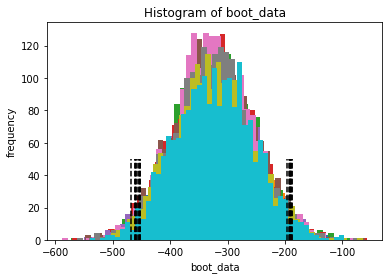

In [42]:
# только revenue > 0
lst = []
for i in range(10):
    it = get_bootstrap(df[(df.group == 'A') & (df.revenue > 0)].revenue,
                       df[(df.group == 'B') & (df.revenue > 0)].revenue)
    lst.append(it)
    print(it)
print(f'mean = {mean(lst)}')
if mean(lst) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

0.035229479556409114
0.051770848185399294
0.04578343091449144
0.04071981381265015
0.047501164270655684
0.04333389996494694
0.0433324047965334
0.04399180465719379
0.03912575814917774
0.0490157558771604
mean = 0.04398043601846179
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


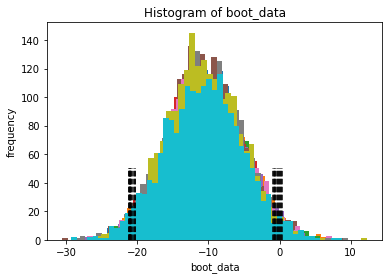

In [43]:
lst = []
for i in range(10):
    it = get_bootstrap(df[df.group == 'A'].revenue, df[df.group == 'B'].revenue)
    lst.append(it)
    print(it)
print(f'mean = {mean(lst)}')
if mean(lst) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

При анализе с ненулевыми значениями p-value крайне мало, но и при нулевых значениях затрат пользователей p-value меньше 0.05, поэтому можно с уверенностью отклонить нулевую гипотезу и принять альтернативную, что различия в доходах контрольной и тестовой группы статистически значимы.

На основании этого, можно выкатить новую модель на остальных пользователей, но стоит еще проверить на отдельных подкатегориях пользователей

In [44]:
# Серия даратфрейма с единым параметром имен
df['general_name'] = df['country'] + '_' + df['platform'] + '_' + df['sex'] + '_' + df['group']

In [45]:
# количество пользователей в каждой подкатегории
df[df.revenue > 0].groupby('general_name').agg({'revenue': 'count'}).sort_values(by='revenue')

,revenue
general_name,
Sweden_android_female_A,6
Sweden_ios_female_A,7
Russia_android_male_A,8
Sweden_ios_male_A,8
Russia_android_female_A,11
Russia_ios_male_A,11
Russia_ios_female_A,13
Sweden_android_male_A,14
Sweden_ios_male_B,24


In [46]:
# мода в каждой подкатегории с заплатившими пользователями
df[df.revenue > 0].groupby('general_name').agg(lambda x: mode(x)[0])[['revenue']].sort_values(by='revenue')

,revenue
general_name,
Russia_android_male_A,208
Sweden_ios_female_A,208
Russia_android_female_A,298
Russia_ios_female_A,300
Russia_ios_male_A,300
Sweden_android_male_A,300
Sweden_android_female_A,301
Sweden_ios_male_A,301
Russia_android_male_B,1909


In [47]:
# среднее значение доходов подкатегорий на пользователя
df.groupby('general_name').agg({'revenue': 'mean'}).sort_values(by='revenue')

,revenue
general_name,
Russia_android_male_A,18.032922
Sweden_android_female_A,25.586420
Russia_android_female_A,34.756554
Sweden_ios_male_A,35.442953
Russia_ios_male_A,43.883117
Sweden_ios_female_A,44.493333
Russia_ios_male_B,48.357642
Russia_android_male_B,51.374606
Russia_android_female_B,54.762810


In [48]:
# среднее значение доходов подкатегорий на заплатившего пользователя 
df[df.revenue > 0].groupby('general_name').agg({'revenue': 'mean'}).sort_values(by='revenue')

,revenue
general_name,
Russia_android_male_A,547.750000
Sweden_ios_male_A,660.125000
Sweden_android_female_A,690.833333
Russia_android_female_A,843.636364
Russia_ios_female_A,892.923077
Russia_ios_male_A,921.545455
Sweden_ios_female_A,953.428571
Russia_ios_male_B,987.877551
Sweden_android_female_B,1149.272727


Из всех значений контрольной и тестовой групп наиболее сильно выбиваются мужчины на андроиде из Швеции. Далее представлены графики

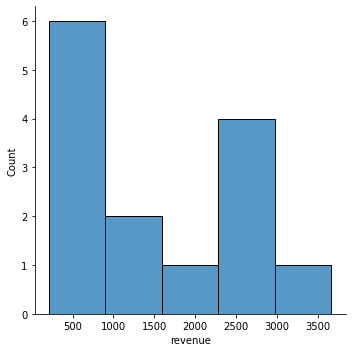

In [49]:
# только revenue > 0
sns.displot(df.query('group == "A" and platform == "android" and country == "Sweden" \
                      and sex == "male" and revenue > 0').revenue, kde=False)

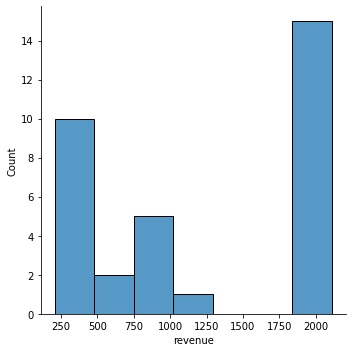

In [50]:
# только revenue > 0
sns.displot(df.query('group == "B" and platform == "android" and country == "Sweden" \
                      and sex == "male" and revenue > 0').revenue, kde=False)

На графиках видно, что тестовая группа не платила больше 2000, в то время как в контрольной группе значения достигают 3500.

С помощью метода bootstrap можно найти значение p-value для показателей дохода от мужчин на андроиде из Швеции

0.10453215197736827
0.10414070790707575
0.10303998329690175
0.11509894943385379
0.09777874125739612
0.11664757197258155
0.09509759877101204
0.1101049575212328
0.12285961225305886
0.10159701655184877
mean = 0.10708972909423298
p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами


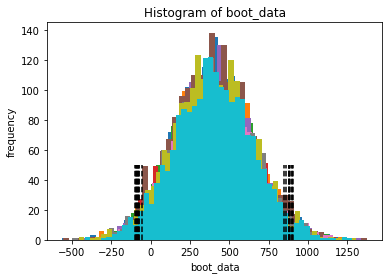

In [51]:
# только revenue > 0
lst = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" and country == "Sweden" \
                                 and sex == "male" and revenue > 0').revenue,
                       df.query('group == "B" and platform == "android" and country == "Sweden" \
                                 and sex == "male" and revenue > 0').revenue)
    lst.append(it)
    print(it)
print(f'mean = {mean(lst)}')
if mean(lst) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

0.0034248786851980963
0.0027562959642545236
0.0033283440679974137
0.0020451156204812073
0.002329649056269384
0.003392043374766742
0.0025642108172952635
0.0031787404291904087
0.0019944955606103145
0.0024513704380812983
mean = 0.0027465144014144653
p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами


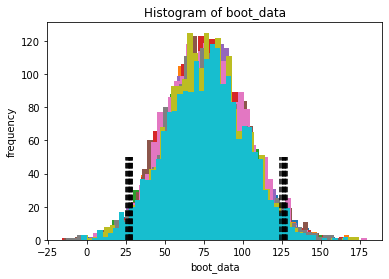

In [52]:
lst = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" \
                                 and country == "Sweden" and sex == "male"').revenue,
                       df.query('group == "B" and platform == "android" \
                                 and country == "Sweden" and sex == "male"').revenue)
    lst.append(it)
    print(it)
print(f'mean = {mean(lst)}')
if mean(lst) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

Видно, что статистически значимые различия имеются только у заплативших пользователей.

Можно рассмотреть более подробно более крупные категории, чтобы проверить, есть ли на более высоких уровнях статистические различия

In [53]:
# Серии даратфрейма с именами без одного параметра
df['without_platform'] = df['sex'] + '_' + df['country'] + '_' + df['group']
df['without_sex'] = df['country'] + '_' + df['platform'] + '_' + df['group']
df['without_country'] = df['platform'] + '_' + df['sex'] + '_' + df['group']

Созданы серии датафрейма, по которым можно рассматривать более крупные подкатегории пользователей

In [54]:
# среднее значение доходов подкатегорий на пользователя
df.groupby('without_platform').agg({'revenue': 'mean'}).sort_values(by='revenue')

,revenue
without_platform,
male_Russia_A,30.630802
female_Sweden_A,34.676282
female_Russia_A,47.365079
male_Russia_B,50.043632
female_Russia_B,56.632029
male_Sweden_B,64.404553
female_Sweden_B,72.815227
male_Sweden_A,88.012862


In [55]:
# среднее значение доходов подкатегорий на заплатившего пользователя 
df[df.revenue > 0].groupby('without_platform').agg({'revenue': 'mean'}).sort_values(by='revenue')

,revenue
without_platform,
male_Russia_A,764.157895
female_Sweden_A,832.230769
female_Russia_A,870.333333
male_Russia_B,1102.417476
male_Sweden_A,1244.181818
male_Sweden_B,1290.350877
female_Russia_B,1339.287234
female_Sweden_B,1418.683333


0.7916333898527212
0.784621081383835
0.7839584727073103
0.7899425306923569
0.8006814282090914
0.7983042812821692
0.802107153569799
0.8237966584594685
0.7852540878306398
0.7634985723821055
mean = 0.7923797656369497
p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами


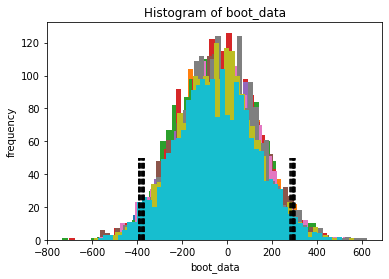

In [56]:
# только revenue > 0
lst = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and sex == "male" \
                                 and country == "Sweden" and revenue > 0').revenue,
                       df.query('group == "B" and sex == "male" \
                                 and country == "Sweden" and revenue > 0').revenue)
    lst.append(it)
    print(it)
print(f'mean = {mean(lst)}')
if mean(lst) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

0.12119494164425028
0.14050504147018023
0.13991498220808546
0.131718101193114
0.13860486834234584
0.15324345561159158
0.14779763740331012
0.13762681663212772
0.1453883593737473
0.1354227913672977
mean = 0.13914169952460503
p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами


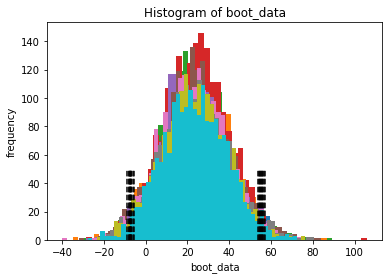

In [57]:
lst = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and sex == "male" and country == "Sweden"').revenue,
                       df.query('group == "B" and sex == "male" and country == "Sweden"').revenue)
    lst.append(it)
    print(it)
print(f'mean = {mean(lst)}')
if mean(lst) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

Показатели по полу и стране не выявили статистически значимых различий

In [58]:
# среднее значение доходов подкатегорий на пользователя
df.groupby('without_sex').agg({'revenue': 'mean'}).sort_values(by='revenue')

,revenue
without_sex,
Russia_android_A,26.788235
Sweden_ios_A,39.983278
Russia_android_B,53.029056
Russia_ios_B,53.642502
Russia_ios_A,53.691358
Sweden_android_B,58.728801
Sweden_android_A,80.975309
Sweden_ios_B,81.631737


In [59]:
# среднее значение доходов подкатегорий на заплатившего пользователя 
df[df.revenue > 0].groupby('without_sex').agg({'revenue': 'mean'}).sort_values(by='revenue')

,revenue
without_sex,
Russia_android_A,719.052632
Sweden_ios_A,797.000000
Russia_ios_A,906.041667
Russia_ios_B,1149.319149
Sweden_android_B,1164.787879
Russia_android_B,1275.786408
Sweden_android_A,1311.800000
Sweden_ios_B,1603.823529


0.360720684861801
0.34832941004184237
0.38258886534980996
0.37721255463211534
0.36420038591535786
0.35584180934801346
0.36049438109600296
0.3719583338764151
0.38503060875225503
0.39245026818217965
mean = 0.36988273020557927
p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами


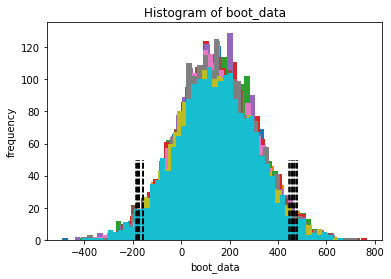

In [60]:
# только revenue > 0
lst = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" \
                                 and country == "Sweden" and revenue > 0').revenue,
                       df.query('group == "B" and platform == "android" \
                                 and country == "Sweden" and revenue > 0').revenue)
    lst.append(it)
    print(it)
print(f'mean = {mean(lst)}')
if mean(lst) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

0.12928128911486506
0.11113586286771131
0.11951813019986778
0.11127453327330637
0.1140904157301702
0.11237924870169691
0.10618269480907953
0.12053896885825749
0.11664560770014931
0.11038934795318604
mean = 0.115143609920829
p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами


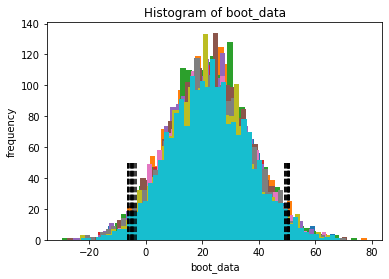

In [61]:
lst = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" and country == "Sweden"').revenue,
                       df.query('group == "B" and platform == "android" and country == "Sweden"').revenue)
    lst.append(it)
    print(it)
print(f'mean = {mean(lst)}')
if mean(lst) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

Показатели по платформе и стране не выявили статистически значимых различий

In [62]:
# среднее значение доходов подкатегорий на пользователя
df.groupby('without_country').agg({'revenue': 'mean'}).sort_values(by='revenue')

,revenue
without_country,
android_female_A,31.293706
ios_male_A,40.573684
android_male_B,54.356658
ios_male_B,55.485294
android_female_B,55.656517
ios_female_A,56.425926
android_male_A,65.365432
ios_female_B,70.279605


In [63]:
# среднее значение доходов подкатегорий на заплатившего пользователя 
df[df.revenue > 0].groupby('without_country').agg({'revenue': 'mean'}).sort_values(by='revenue')

,revenue
without_country,
android_female_A,789.705882
ios_male_A,811.473684
ios_female_A,914.100000
ios_male_B,1137.068493
android_male_B,1196.471264
android_male_A,1203.318182
android_female_B,1270.597561
ios_female_B,1483.680556


0.9488652173394052
0.970834564981764
0.9752771812778612
0.9474690216844163
0.9392595766083675
0.9609521322711154
0.9800973031243704
0.9693854423930383
0.9803234829543348
0.9725706610502134
mean = 0.9645034583684886
p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами


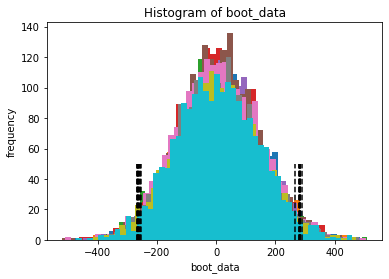

In [64]:
# только revenue > 0
lst = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" \
                                 and sex == "male" and revenue > 0').revenue,
                       df.query('group == "B" and platform == "android" \
                                 and sex == "male" and revenue > 0').revenue)
    lst.append(it)
    print(it)
print(f'mean = {mean(lst)}')
if mean(lst) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

0.31610072672314693
0.29910954979867965
0.3193951307642925
0.3136766717697448
0.30607443811906665
0.3164804247248346
0.31513062675705716
0.310828877373978
0.30177897072943594
0.29655591571929607
mean = 0.3095131332479532
p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами


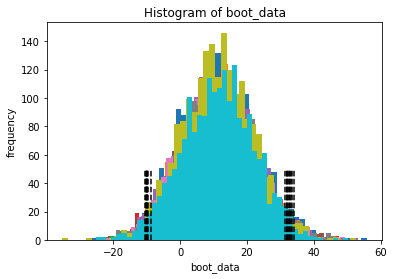

In [65]:
lst = []
for i in range(10):
    it = get_bootstrap(df.query('group == "A" and platform == "android" and sex == "male"').revenue,
                       df.query('group == "B" and platform == "android" and sex == "male"').revenue)
    lst.append(it)
    print(it)
print(f'mean = {mean(lst)}')
if mean(lst) < 0.05:
    print('p-value < 0.05 -> Есть статистически значимые различия в доходах между двумя данными группами')
else:
    print('p-value >= 0.05 -> Нельзя утверждать, что есть различия в доходах между двумя данными группами')

Показатели по платформе и полу не выявили статистически значимых различий

Далее представлены A/B тестирования всех подкатегорий пользователей. Из результатов видно, что тестовая группа сразу в нескольких подкатегориях статически более успешная, чем контрольная группа. Единственно, есть неудачное отклонение среди мужчин на андроиде из Швеции, которое было выявлено ранее 

In [66]:
# категория тестирования: p_value revenue>0, p_value revenue>=0
# - означает в сторону улучшения, + в сторону ухудшения 


# A/B:                  -e-06, -0.04    --

# male:                 -0.12, -0.83
# female:               -e-08, -e-03    --
# android:              -0.02, -0.28    -
# ios:                  -e-05, -0.06    -
# Russia:               -e-07, -0.01    --
# Sweden:               -0.02, -0.43    -

# male/android:         +0.96, +0.30
# male/ios:             -0.01, -0.13    -
# male/Russia:          -e-03, -e-03    --
# male/Sweden:          -0.79, +0.13
# female/android:       -e-06, -e-03    --
# female/ios:           -e-04, -0.27    -
# female/Russia:        -e-05, -0.29    -
# female/Sweden:        -e-03, -e-03    --
# android/Russia:       -e-09, -e-04    --
# android/Sweden:       +0.36, +0.11
# ios/Russia:           -0.05, -0.98
# ios/Sweden:           -e-06, -e-03    --

# male/android/Russia:  -e-10, -e-05    --
# male/android/Sweden:  +0.10, +e-03     +
# male/ios/Russia:      -0.70, -0.71
# male/ios/Sweden:      -e-06, -0.05    -
# female/android/Russia:-e-04, -0.06    -
# female/android/Sweden:-e-03, -0.01    --
# female/ios/Russia:    -0.01, +0.58    -
# female/ios/Sweden:    -e-03, -0.04    --

Данное исследование показало, что значимые статистические различия имеются между контрольной и тестовой группы

### Выводы

А/В-тестирование выявило статистическую разницу между контрольной и тестовой группы, которая позволяет прийти к выводу, что можно выкатить новую модель на остальных пользователях. В тестовой группе средний доход на пользователя вырос на 22,29%. Единственно, можно заметить, что мужчины из Швеции, пользующиеся платформой android стали меньше вкладывать финансовых средств в приложении, поэтому, следует понять из-за чего это происходит, получив дополнительные данные об активности в течение дня/недели. 

## Задание №2

Реализация дашборда https://public.tableau.com/app/profile/artem.gonets/viz/FinalprojectKarpov/Stories